In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

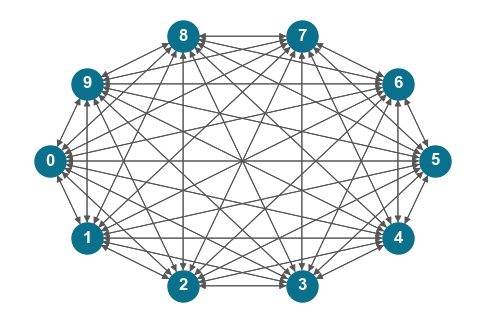

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

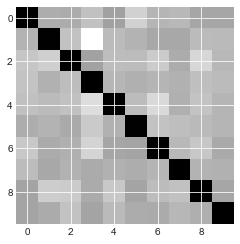

In [4]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


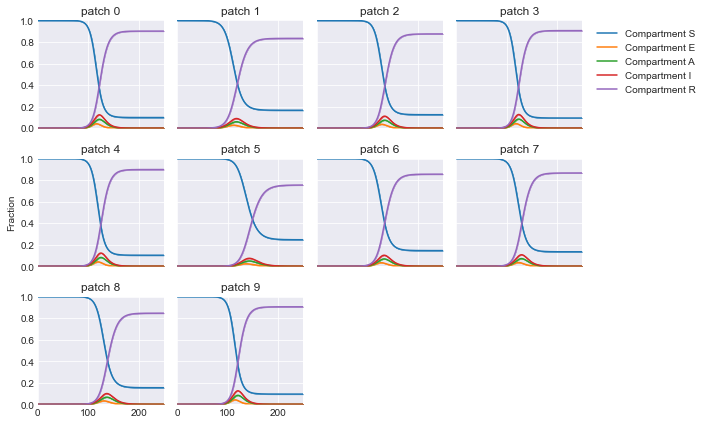

In [5]:
def gen_ref_traj(beta_A = 0.025, beta_I=0.04, alpha =1/3, gamma=1/2, mu=1/7, M=10, timesteps=100, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/alpha, 0) # call this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # call this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [100, 130]
122 0.115495555 0.11485970902444628
115 0.07794935 0.07862578585737402
108 0.03758618 0.03816276944720538
122 0.31115723 0.310948927806922
115 0.15111935 0.15111949099898606
108 0.061619554 0.06312539207777593
108 0.044133984 0.044848207372835576
115 0.08916437 0.09144870216273984
101 0.017458897 0.01902299966372635
101 0.02596897 0.026580074440766474
122 0.35336334 0.3527061581033814
108 0.07138787 0.07070689302056402
122 0.06262032 0.06255207782073509
115 0.03021369 0.031927032153197483
101 0.004769402 0.004024647268411622
108 0.019925488 0.019099049620401463
101 0.0074247397 0.008465914672323403
115 0.05154792 0.05151468244051434
122 0.12172008 0.1212220506071881
115 0.09844407 0.10037359899555512
108 0.053759873 0.05470929372028636
122 0.4003779 0.40046545064972566
101 0.035179652 0.03607200077313111
115 0.21379712 0.2137005461126251
108 0.07075185 0.06997450663145788
122 0.08356458 0.08468051794097001
115 0.08735776 0.0886972124922

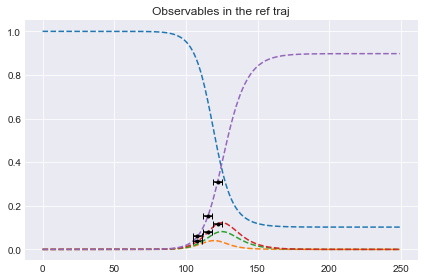

In [6]:
npoints = 3
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.001, start_time=100, end_time=130)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [7]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1) # call this alpha
    tmat.add_transition('E', 'I', 2, 1) # call this gamma
    tmat.add_transition('A', 'R',5, 2) # mu
    tmat.add_transition('I', 'R', 5, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 8
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.27s/it]


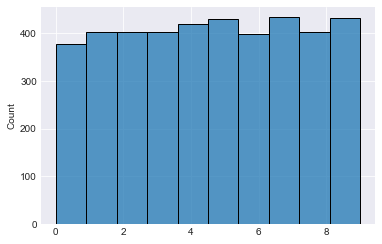

In [8]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [9]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


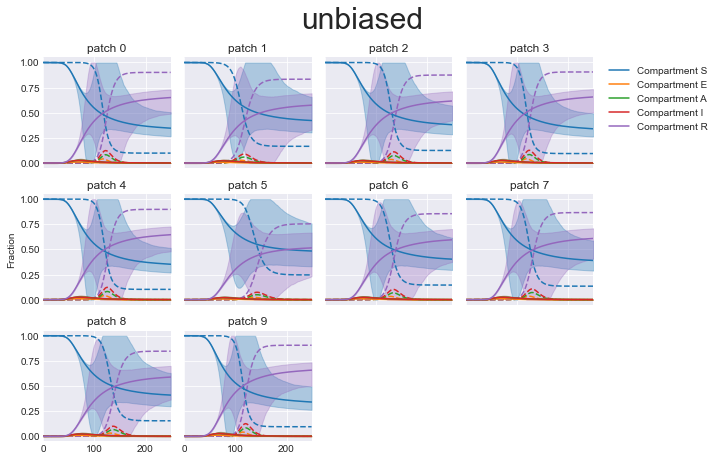

In [10]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0205 - weight-entropy: 6.6751
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0152 - weight-entropy: 6.3226
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0163 - weight-entropy: 6.2740
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0155 - weight-entropy: 6.2805
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0134 - weight-entropy: 6.3036
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0100 - weight-entropy: 6.3046
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0064 - weight-entropy: 6.2064
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0061 - weight-entropy: 5.9748
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0069 - weight-entropy: 5.8434
Epoch 10/500
4/4 [==============================] - 0s 1ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 4.7394
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0039 - weight-entropy: 4.9269
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0043 - weight-entropy: 5.0193
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0041 - weight-entropy: 4.9037
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.7567
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.8273
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0035 - weight-entropy: 4.8575
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 4.7937
Epoch 87/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 4.8170
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.003

4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.2098
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1862
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 4.5914
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1172
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.2448
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1531
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.3856
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.3314
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 3.8440
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.0102
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.8247
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.2050
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.2258
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.2441
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.2109
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1432
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.2750
Epoch 243/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1641
Epoch 244/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.3151
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.2271
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.9085
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.5447
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1912
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1798
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.4041
Epoch 320/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0582
Epoch 321/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.5063
Epoch 322/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.9422
Epoch 392/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.8046
Epoch 393/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0341
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1129
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6578
Epoch 396/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.7331
Epoch 397/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.6542
Epoch 398/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6143
Epoch 399/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1061
Epoch 400/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6963
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6127
Epoch 471/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.7443
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.9548
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.8253
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.3622
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.5985
Epoch 476/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.8514
Epoch 477/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.6548
Epoch 478/500
4/4 [==============================] - 0s 1ms/step - lo

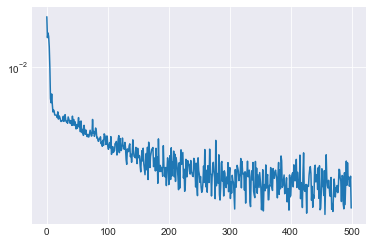

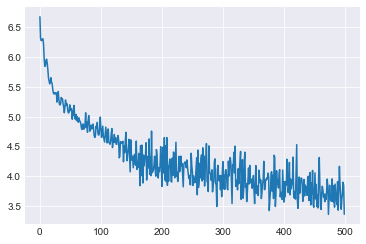

In [11]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [12]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


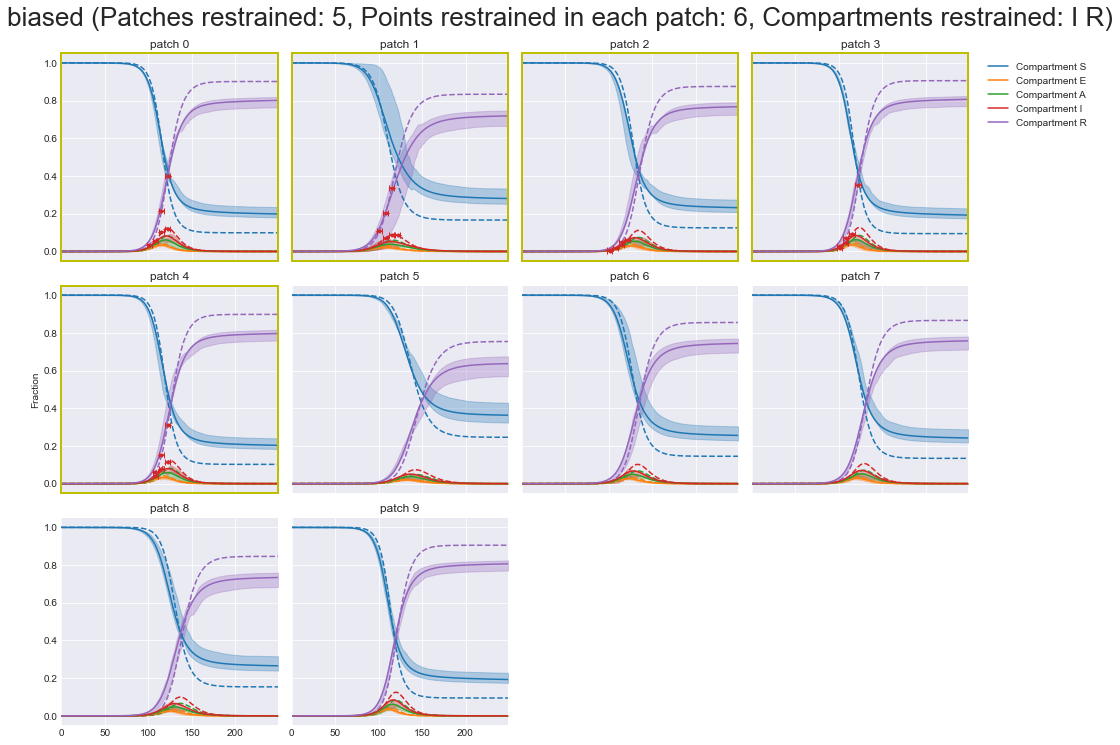

In [13]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

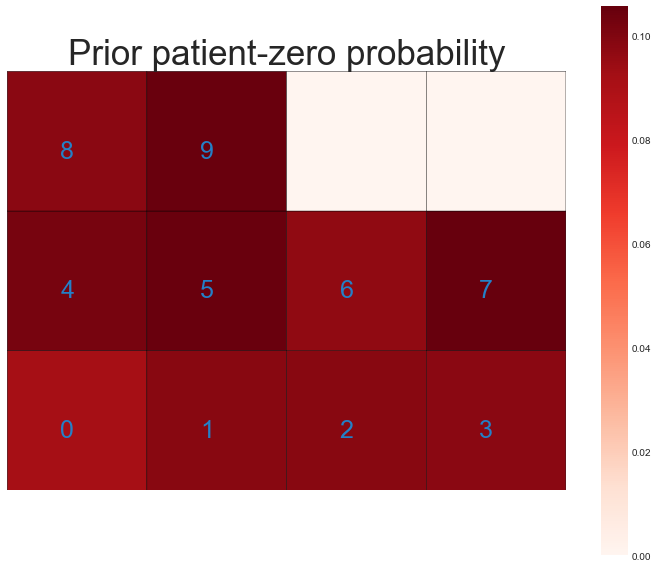

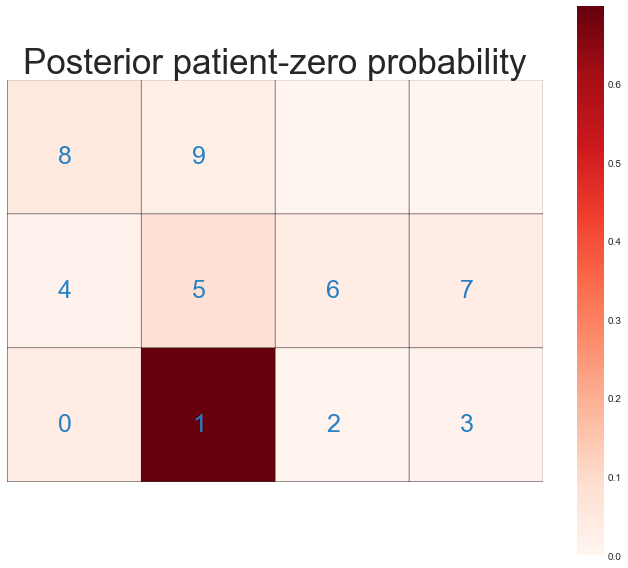

In [14]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

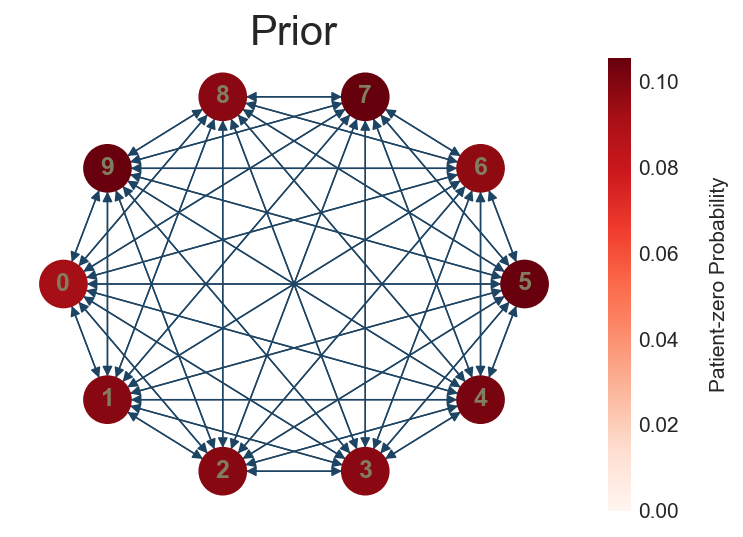

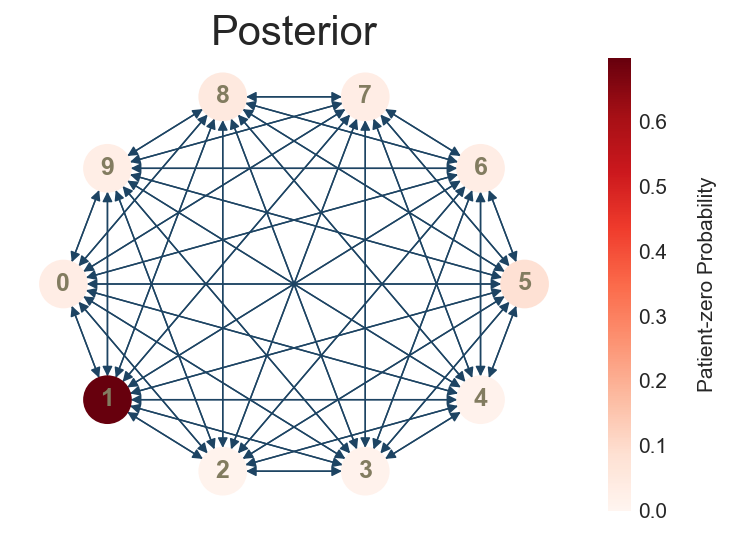

In [15]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [16]:
def p0_loss(trajs, weights, M=10, true_p0_node=1):
    '''Returns cross-entropy loss for p0 based on sampled trajs and maxent weights inputs'''
    prior_exposed_patch = maxentep.exposed_finder(trajs)
    weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=weights)
    true_p0 = np.zeros(M)
    true_p0[true_p0_node] = 1
    loss = np.sum(-(true_p0 * np.log(weighted_exposed_prob) + (1-true_p0)*np.log(1-weighted_exposed_prob)))
    return loss


def traj_loss(ref_traj, trajs, weights):
    '''Returns RMSE loss for predicted traj based on ref_traj, sampled trajs and maxent weights inputs'''
    population_fraction = population/np.sum(population)
    M = trajs.shape[2]
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    weights /= np.sum(weights)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * weights[:, np.newaxis, np.newaxis], axis=0)
    rmse = np.sqrt(np.mean(np.mean(np.mean((ref_traj[0] - mtrajs_counties)**2, axis = 2), axis =0)))
#     mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return rmse
traj_rmse_1 = traj_loss(ref_traj_1, trajs_1, me_w_1)
p0_loss_1 = p0_loss(trajs_1,me_w_1)

In [51]:
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss_1:.3f}, Traj RMSE : {traj_rmse_1:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])


P0 cross-entropy : 0.667, Traj RMSE : 0.050
Top 5 posterior probabilities for P0: 
 [(0.6987863996515982, 'patch 1'), (0.08286348949925619, 'patch 5'), (0.04982524945228936, 'patch 8'), (0.035295181360000434, 'patch 7'), (0.03451339184695294, 'patch 6')]


 # Case 2

6.9

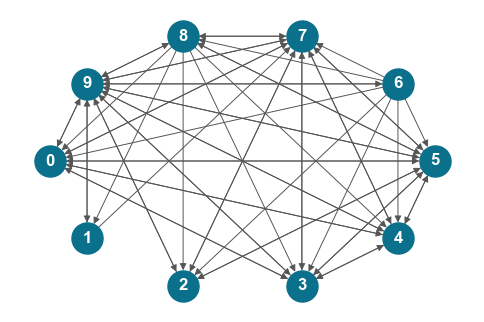

In [18]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [19]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


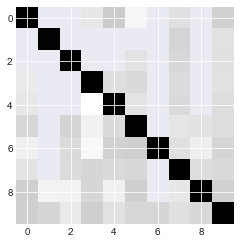

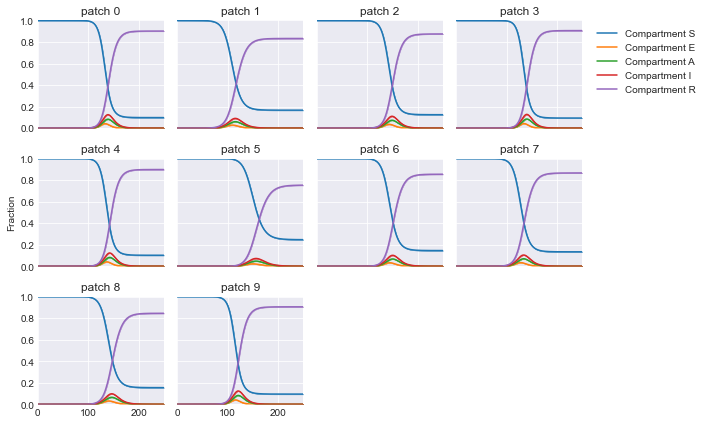

In [20]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
108 0.0016564392 0.0018610637260837962
101 0.00057700824 0.000493670071752575
122 0.0120278215 0.013856752442312104
115 0.006881315 0.006637135317645811
108 0.0024070926 0.0017634741982279767
101 0.0008227728 0.0
101 0.00051752204 0.0
115 0.0036100454 0.0036622104955416016
108 0.0014132856 0.0006737226194626519
101 0.00076559925 0.0023086138475971766
122 0.014774955 0.014270058669494665
115 0.0058291745 0.005384416734599735
108 0.07896448 0.07973626981881086
122 0.079048894 0.07987239849972408
101 0.053787287 0.055950523273947665
122 0.526785 0.5281215440093119
108 0.23989142 0.23952224293718116
115 0.38220358 0.38196419977139867
122 0.011765068 0.011817293401476341
101 0.00060696155 0.0
115 0.0046775597 0.006060502049225012
115 0.007143983 0.007530895990105998
122 0.019214252 0.01973623973959323
108 0.0025273017 0.0037245615302534695
101 0.026829911 0.0264496042468166
108 0.061291493 0.061720191412406526
122 0.120776124 0.1211380201843

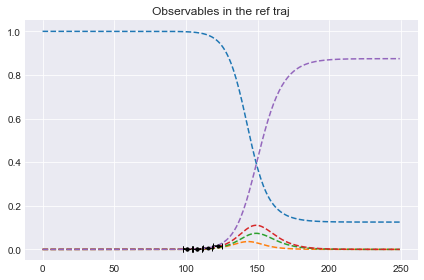

In [21]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.14s/it]


Plotting 10 patches in a 3 x 4 grid


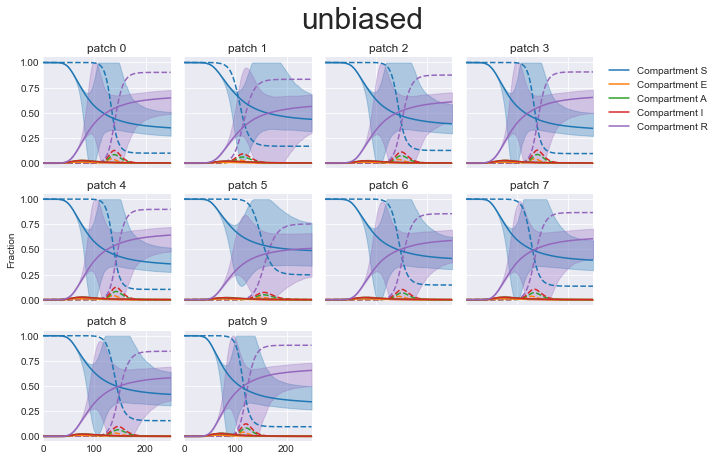

In [22]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0249 - weight-entropy: 6.7016
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0188 - weight-entropy: 6.3638
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0199 - weight-entropy: 6.2953
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0201 - weight-entropy: 6.2788
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0200 - weight-entropy: 6.2808
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0197 - weight-entropy: 6.2915
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0192 - weight-entropy: 6.3092
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0186 - weight-entropy: 6.3323
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0176 - weight-entropy: 6.3575
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.8626
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.9250
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.9818
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.7646
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6545
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.7346
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.9047
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.9116
Epoch 87/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.7172
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.001

4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.9379
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.0293
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 3.5904
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.2490
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.4477
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.2976
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.3409
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 3.5649
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.5478
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.3254
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.9262
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2068e-04 - weight-entropy: 2.7899
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.8716
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 9.1243e-04 - weight-entropy: 3.1309
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 7.4292e-04 - weight-entropy: 3.2130
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.2239
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 9.2204e-04 - weight-entropy: 3.1913
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 9.3179e-04 - weight-entropy: 3.0031
Epoch 243/500
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 8.3503e-04 - weight-entropy: 2.8126
Epoch 311/500
4/4 [==============================] - 0s 1ms/step - loss: 7.4236e-04 - weight-entropy: 2.8509
Epoch 312/500
4/4 [==============================] - 0s 1ms/step - loss: 5.8192e-04 - weight-entropy: 2.8404
Epoch 313/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.2179
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7192e-04 - weight-entropy: 2.6406
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3518e-04 - weight-entropy: 2.7784
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.2634
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7125e-04 - weight-entropy: 2.6908
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 2.5744
Epoch 319/500
4/4 [==========================

4/4 [==============================] - 0s 2ms/step - loss: 7.3844e-04 - weight-entropy: 2.5291
Epoch 387/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7916e-04 - weight-entropy: 2.4998
Epoch 388/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.2652
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 8.1949e-04 - weight-entropy: 2.6378
Epoch 390/500
4/4 [==============================] - 0s 1ms/step - loss: 9.6402e-04 - weight-entropy: 2.9063
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 9.2870e-04 - weight-entropy: 2.5695
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 2.8956
Epoch 393/500
4/4 [==============================] - 0s 1ms/step - loss: 8.0125e-04 - weight-entropy: 2.7678
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6926e-04 - weight-entropy: 2.7531
Epoch 395/500
4/4 [======================

Epoch 462/500
4/4 [==============================] - 0s 1ms/step - loss: 7.6462e-04 - weight-entropy: 2.3680
Epoch 463/500
4/4 [==============================] - 0s 1ms/step - loss: 8.2192e-04 - weight-entropy: 2.4035
Epoch 464/500
4/4 [==============================] - 0s 1ms/step - loss: 6.7423e-04 - weight-entropy: 2.9226
Epoch 465/500
4/4 [==============================] - 0s 1ms/step - loss: 8.0894e-04 - weight-entropy: 2.5630
Epoch 466/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.9881
Epoch 467/500
4/4 [==============================] - 0s 1ms/step - loss: 5.9176e-04 - weight-entropy: 2.5358
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.9114
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4192e-04 - weight-entropy: 2.2750
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 7.9033e-04 - weight-entropy: 2.3389
Epoch 471/500
4/4 [========

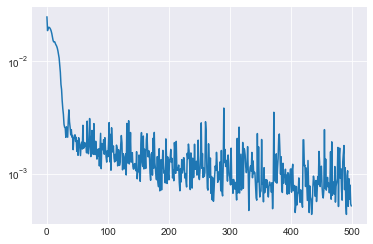

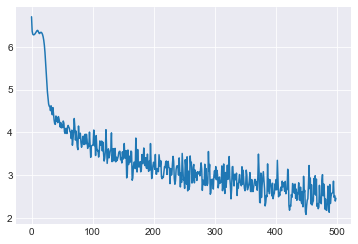

In [23]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


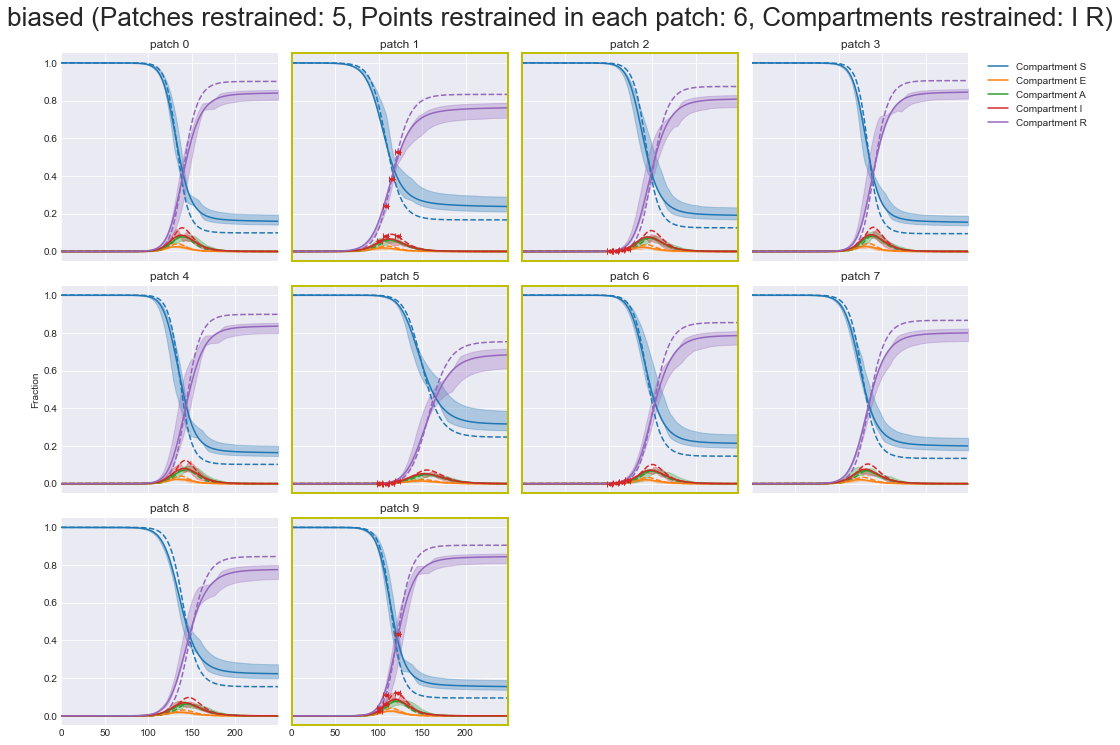

In [24]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

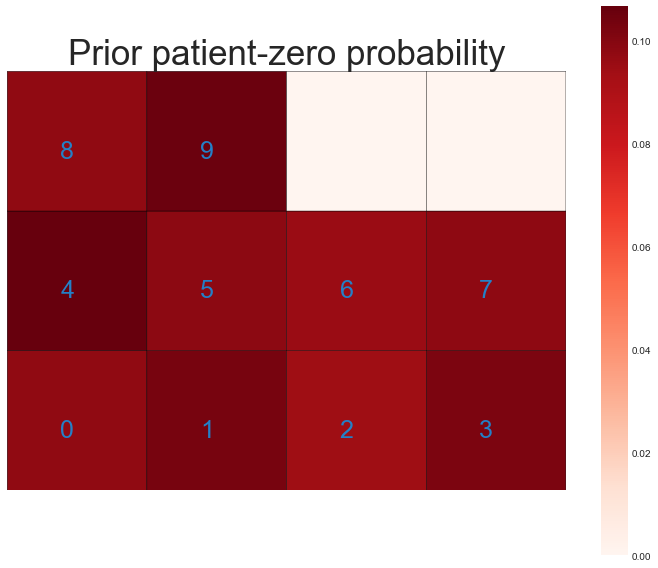

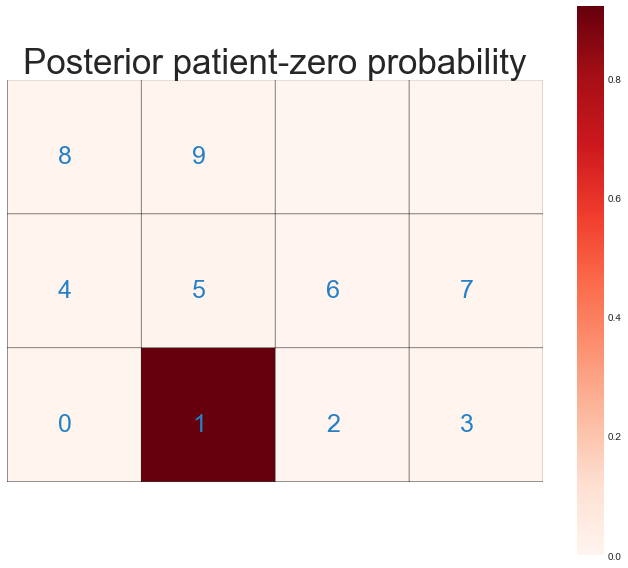

In [25]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

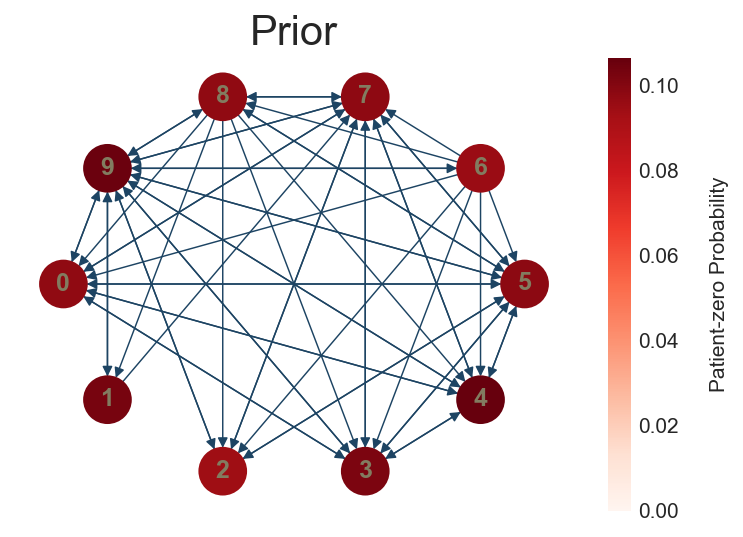

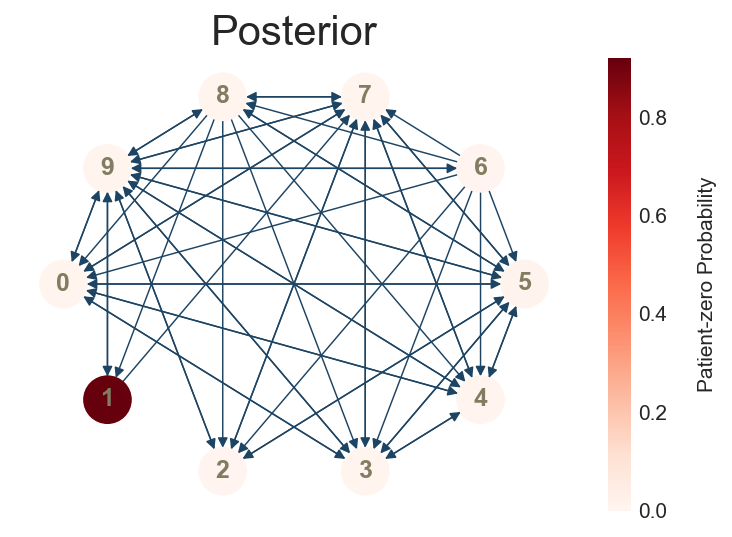

In [26]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [50]:
traj_rmse_2 = traj_loss(sparse_ref_traj_2, sparse_trajs_2, me_w_2)
p0_loss_2 = p0_loss(sparse_trajs_2,me_w_2)
print(f'P0 cross-entropy : {p0_loss_2:.3f}, Traj RMSE : {traj_rmse_2:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

P0 cross-entropy : 0.161, Traj RMSE : 0.032
Top 5 posterior probabilities for P0: 
 [(0.9211336512592351, 'patch 1'), (0.010969108668737163, 'patch 5'), (0.010645916321949816, 'patch 8'), (0.010073586704081896, 'patch 7'), (0.009609348290458144, 'patch 4')]


# Case 3

4.5

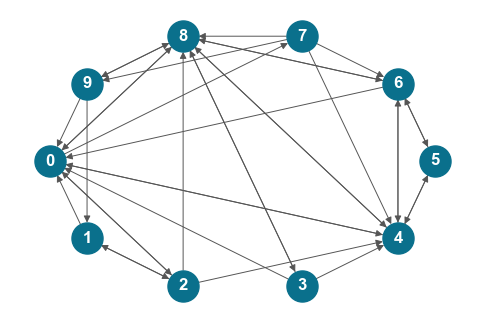

In [29]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


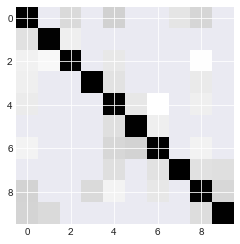

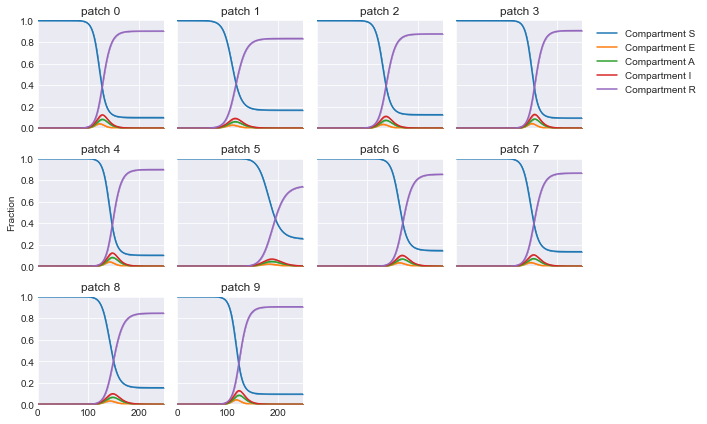

In [30]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
101 0.0037364513 0.0038929578061614816
108 0.00954389 0.009776071169700374
122 0.049908727 0.04931141133849008
115 0.039811905 0.03957398374373468
122 0.095451884 0.09523464873805997
101 0.0059922775 0.006522294281921853
122 0.014523945 0.014787905126439217
101 0.00071217475 8.253283851586413e-05
108 0.0020663647 0.0015941063405034207
101 0.0010012954 0.0
108 0.0029685989 0.002028245313443992
122 0.023410235 0.024339828928698754
108 0.0009822365 0.0
122 0.0075553097 0.004504075263540451
115 0.0028076486 0.00436731343517147
122 0.011567414 0.008936405347988077
101 0.00045773902 0.0
115 0.004078666 0.0026122418860973365
115 5.5006116e-05 0.00019695927919272693
122 0.00016722619 0.0
101 5.631101e-06 0.0006971698520459203
101 7.401649e-06 0.0007021507925284797
108 2.3599398e-05 0.0
115 7.4223884e-05 0.001908016629248648
115 0.00033398965 0.0
108 0.000114606264 0.0
101 3.8463822e-05 0.0
101 5.329328e-05 0.0
122 0.0013863131 0.004487843701205

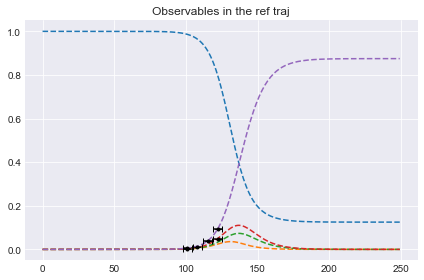

In [31]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.15s/it]


Plotting 10 patches in a 3 x 4 grid


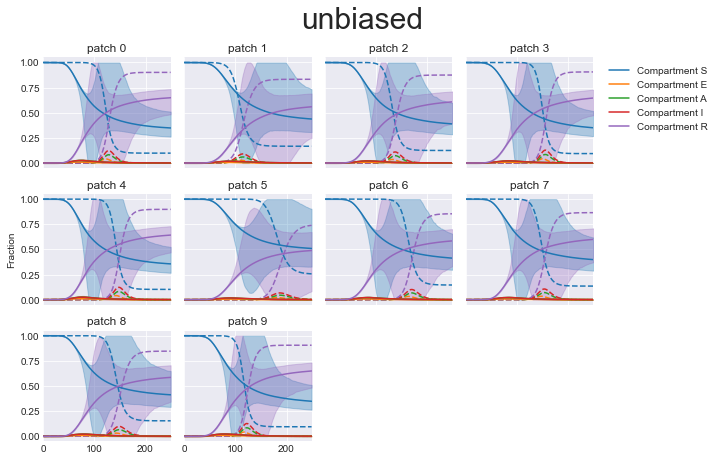

In [32]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0193 - weight-entropy: 6.7166
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 4.2297e-04 - weight-entropy: 6.3758
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 2.7583e-04 - weight-entropy: 6.2916
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 2.7577e-04 - weight-entropy: 6.2585
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 2.8198e-04 - weight-entropy: 6.2412
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 2.8712e-04 - weight-entropy: 6.2311
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 2.9073e-04 - weight-entropy: 6.2245
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 2.9339e-04 - weight-entropy: 6.2205
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 2.9540e-04 - weight-entropy: 6.2178
Epoch 10/500
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 2.3431e-04 - weight-entropy: 6.2668
Epoch 77/500
4/4 [==============================] - 0s 2ms/step - loss: 2.3348e-04 - weight-entropy: 6.2681
Epoch 78/500
4/4 [==============================] - 0s 1ms/step - loss: 2.3109e-04 - weight-entropy: 6.2689
Epoch 79/500
4/4 [==============================] - 0s 2ms/step - loss: 2.3067e-04 - weight-entropy: 6.2694
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 2.2984e-04 - weight-entropy: 6.2700
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 2.2842e-04 - weight-entropy: 6.2709
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 2.2632e-04 - weight-entropy: 6.2710
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 2.2682e-04 - weight-entropy: 6.2722
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 2.2434e-04 - weight-entropy: 6.2729
Epoch 85/500
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 1.5188e-04 - weight-entropy: 6.2495
Epoch 152/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5284e-04 - weight-entropy: 6.2488
Epoch 153/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5059e-04 - weight-entropy: 6.2480
Epoch 154/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4934e-04 - weight-entropy: 6.2471
Epoch 155/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4886e-04 - weight-entropy: 6.2459
Epoch 156/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4986e-04 - weight-entropy: 6.2446
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4501e-04 - weight-entropy: 6.2441
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4961e-04 - weight-entropy: 6.2431
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5296e-04 - weight-entropy: 6.2417
Epoch 160/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 1.1017e-04 - weight-entropy: 6.1709
Epoch 226/500
4/4 [==============================] - 0s 1ms/step - loss: 1.1205e-04 - weight-entropy: 6.1697
Epoch 227/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0509e-04 - weight-entropy: 6.1692
Epoch 228/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0411e-04 - weight-entropy: 6.1671
Epoch 229/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0585e-04 - weight-entropy: 6.1662
Epoch 230/500
4/4 [==============================] - 0s 1ms/step - loss: 1.0696e-04 - weight-entropy: 6.1655
Epoch 231/500
4/4 [==============================] - 0s 1ms/step - loss: 1.1928e-04 - weight-entropy: 6.1644
Epoch 232/500
4/4 [==============================] - 0s 1ms/step - loss: 1.0851e-04 - weight-entropy: 6.1631
Epoch 233/500
4/4 [==============================] - 0s 1ms/step - loss: 1.0735e-04 - weight-entropy: 6.1620
Epoch 234/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 9.7541e-05 - weight-entropy: 6.1069
Epoch 301/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0632e-05 - weight-entropy: 6.1047
Epoch 302/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0175e-04 - weight-entropy: 6.1070
Epoch 303/500
4/4 [==============================] - 0s 1ms/step - loss: 9.2087e-05 - weight-entropy: 6.1039
Epoch 304/500
4/4 [==============================] - 0s 1ms/step - loss: 9.2473e-05 - weight-entropy: 6.1031
Epoch 305/500
4/4 [==============================] - 0s 2ms/step - loss: 9.1680e-05 - weight-entropy: 6.1025
Epoch 306/500
4/4 [==============================] - 0s 1ms/step - loss: 1.0521e-04 - weight-entropy: 6.1025
Epoch 307/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0602e-04 - weight-entropy: 6.1051
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 9.4871e-05 - weight-entropy: 6.1018
Epoch 309/500
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 8.6331e-05 - weight-entropy: 6.0694
Epoch 376/500
4/4 [==============================] - 0s 1ms/step - loss: 9.2837e-05 - weight-entropy: 6.0688
Epoch 377/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9165e-05 - weight-entropy: 6.0675
Epoch 378/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3302e-05 - weight-entropy: 6.0652
Epoch 379/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6293e-05 - weight-entropy: 6.0683
Epoch 380/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9823e-05 - weight-entropy: 6.0621
Epoch 381/500
4/4 [==============================] - 0s 2ms/step - loss: 9.4637e-05 - weight-entropy: 6.0631
Epoch 382/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3059e-05 - weight-entropy: 6.0596
Epoch 383/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6769e-05 - weight-entropy: 6.0628
Epoch 384/500
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 7.9089e-05 - weight-entropy: 6.0326
Epoch 451/500
4/4 [==============================] - 0s 1ms/step - loss: 9.5820e-05 - weight-entropy: 6.0368
Epoch 452/500
4/4 [==============================] - 0s 2ms/step - loss: 9.7768e-05 - weight-entropy: 6.0376
Epoch 453/500
4/4 [==============================] - 0s 1ms/step - loss: 9.5223e-05 - weight-entropy: 6.0361
Epoch 454/500
4/4 [==============================] - 0s 2ms/step - loss: 8.7817e-05 - weight-entropy: 6.0378
Epoch 455/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3006e-05 - weight-entropy: 6.0355
Epoch 456/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8175e-05 - weight-entropy: 6.0333
Epoch 457/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0842e-05 - weight-entropy: 6.0350
Epoch 458/500
4/4 [==============================] - 0s 1ms/step - loss: 9.8961e-05 - weight-entropy: 6.0386
Epoch 459/500
4/4 [==============

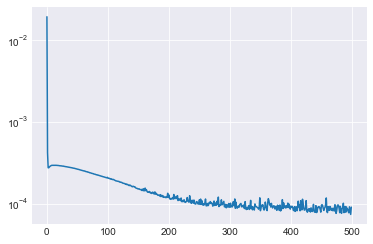

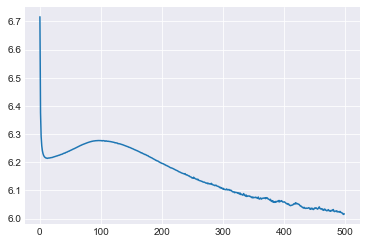

In [33]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

Plotting 10 patches in a 3 x 4 grid


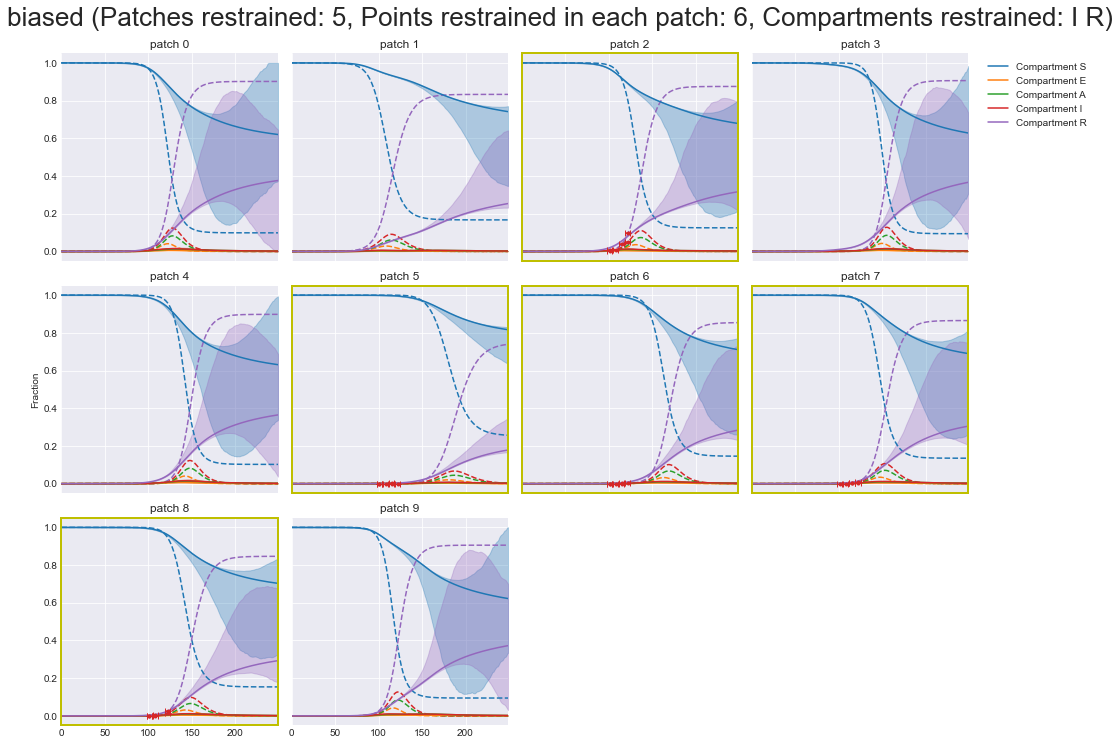

In [34]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

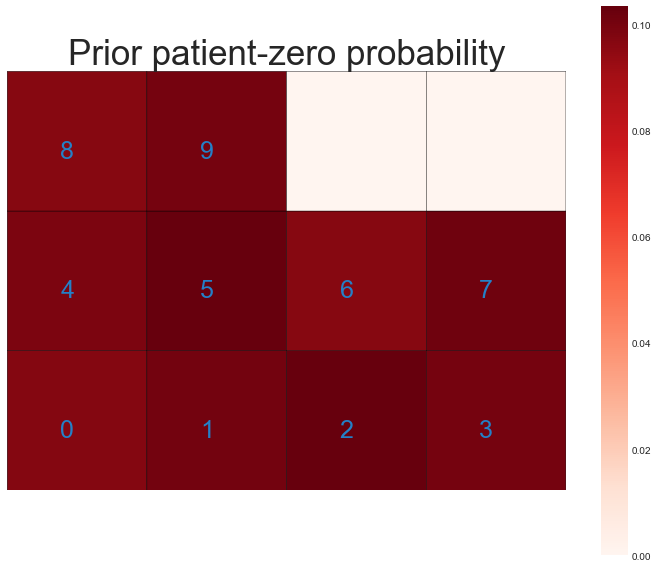

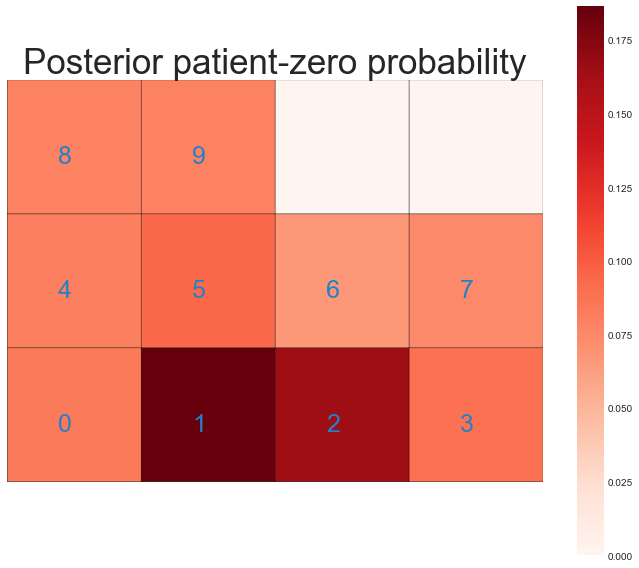

In [35]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

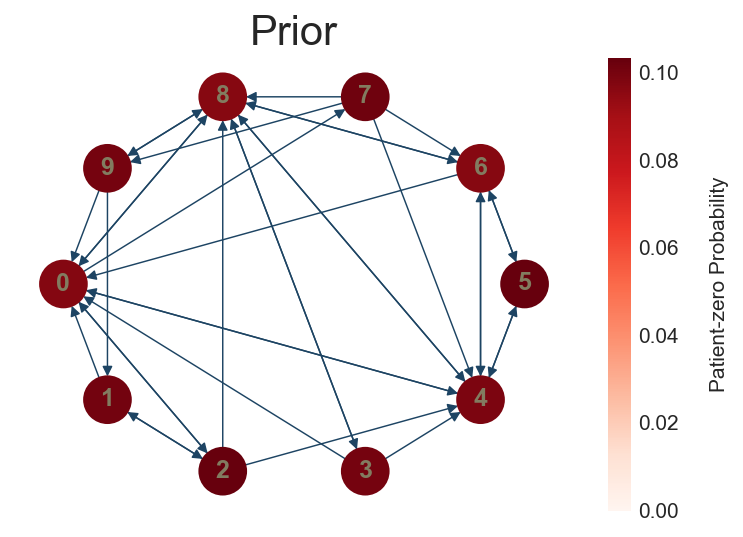

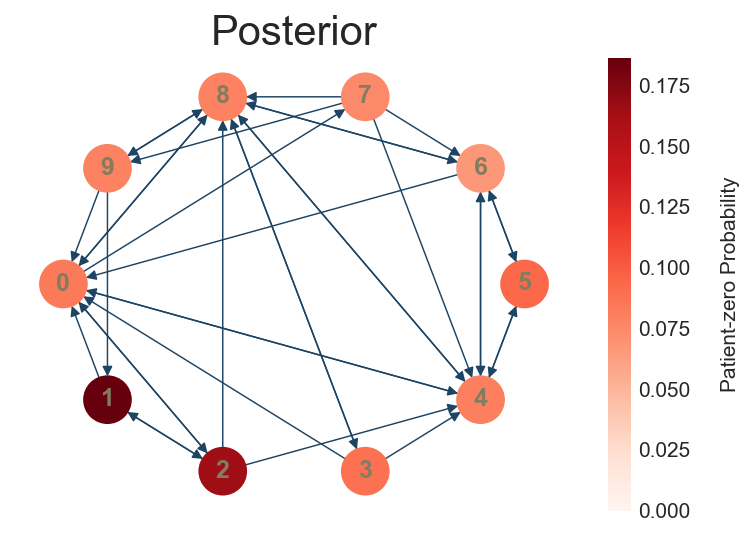

In [36]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [49]:
traj_rmse_3 = traj_loss(sparse_ref_traj_3, sparse_trajs_2, me_w_3)
p0_loss_3 = p0_loss(sparse_trajs_3,me_w_3)
print(f'P0 cross-entropy : {p0_loss_3:.3f}, Traj RMSE : {traj_rmse_3:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

P0 cross-entropy : 2.537, Traj RMSE : 0.157
Top 5 posterior probabilities for P0: 
 [(0.18644813170688979, 'patch 1'), (0.1648073598296904, 'patch 2'), (0.09388382249607058, 'patch 5'), (0.08917839142060512, 'patch 3'), (0.08411344732691718, 'patch 0')]


# Case 4

3.3

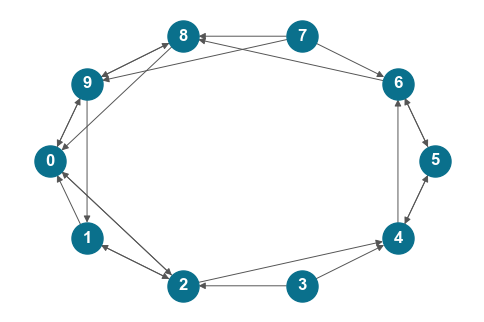

In [38]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


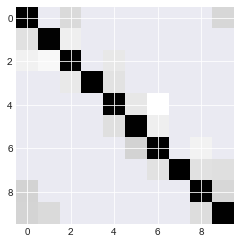

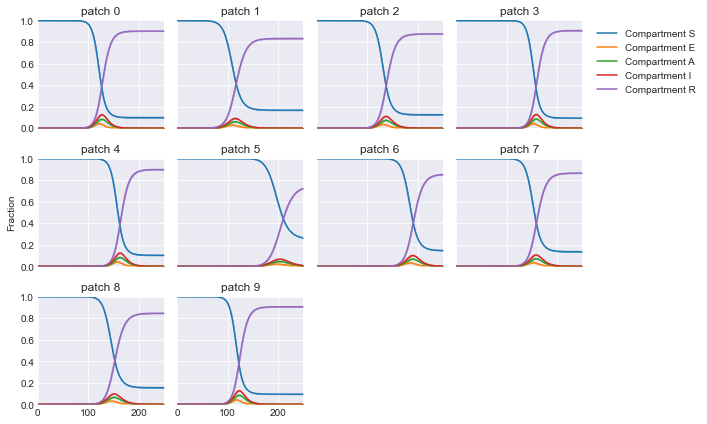

In [39]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [100, 130]
122 0.00422632 0.0021956354897430435
108 0.00055188616 0.0026163790194233274
101 0.00018590406 7.536340675041645e-05
108 0.0007753609 0.0017955336214720728
101 0.00025586816 0.0005422118478939727
122 0.0064798244 0.007088668261990719
108 5.5390883e-06 0.0006953572528410384
101 1.7702583e-06 0.0013036164879013628
122 5.090108e-05 0.0
101 2.332163e-06 0.0
115 2.3147892e-05 4.34615357730595e-05
108 7.409675e-06 0.0
122 0.1099868 0.11022757987133422
101 0.011062703 0.01026615594610663
108 0.029202808 0.029141412079539273
108 0.04565959 0.045724690097778665
122 0.26084226 0.2612408494254107
101 0.016372513 0.015319338646051988
115 0.0042955778 0.004209967862297976
101 0.0005313077 0.0012418476126318176
108 0.00154781 0.002478769922256543
108 0.0022142322 0.0030893062458613213
122 0.01759148 0.01625722169431723
115 0.006405163 0.005058445584878514
108 0.050144795 0.05083856848106881
122 0.12411823 0.1239586577987884
101 0.020411497 0.02027779

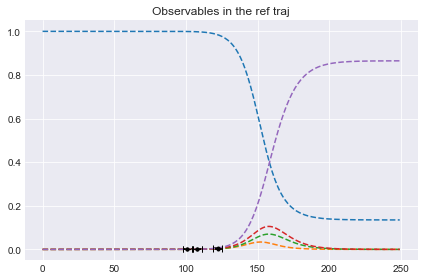

In [40]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.41s/it]


Plotting 10 patches in a 3 x 4 grid


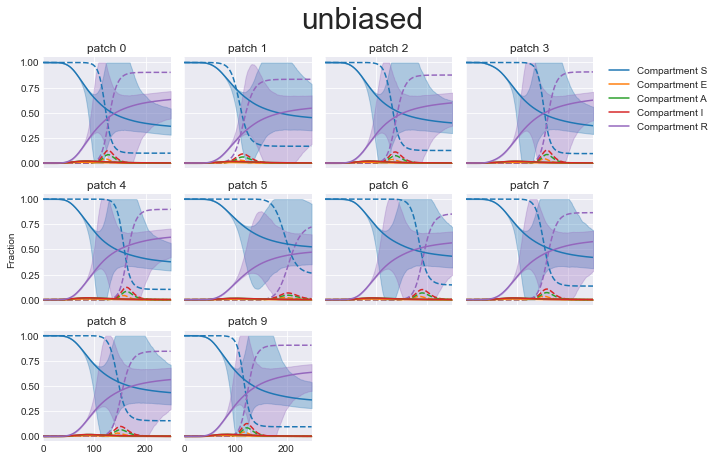

In [41]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0137 - weight-entropy: 6.7362
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0064 - weight-entropy: 6.4485
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0072 - weight-entropy: 6.3788
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - weight-entropy: 6.3563
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0075 - weight-entropy: 6.3490
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - weight-entropy: 6.3494
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0073 - weight-entropy: 6.3558
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0071 - weight-entropy: 6.3654
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0068 - weight-entropy: 6.3789
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 5.9431
Epoch 79/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 5.9204
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 5.9270
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 5.9302
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 5.9167
Epoch 83/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 5.9151
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 5.9114
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 5.9046
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 5.8912
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.001

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.4186
Epoch 156/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 5.4309
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4539
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.4624
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 5.4433
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3957
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.4021
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 5.3828
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 5.3768
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 5.0383
Epoch 233/500
4/4 [==============================] - 0s 1ms/step - loss: 9.0009e-04 - weight-entropy: 4.9553
Epoch 234/500
4/4 [==============================] - 0s 2ms/step - loss: 9.8460e-04 - weight-entropy: 4.9182
Epoch 235/500
4/4 [==============================] - 0s 2ms/step - loss: 9.1630e-04 - weight-entropy: 4.9149
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 5.0083
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 9.3280e-04 - weight-entropy: 4.8804
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 9.4504e-04 - weight-entropy: 4.8719
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.8724
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 9.6903e-04 - weight-entropy: 4.9533
Epoch 241/500
4/4 [==========================

4/4 [==============================] - 0s 1ms/step - loss: 8.1000e-04 - weight-entropy: 4.5103
Epoch 309/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.6561
Epoch 310/500
4/4 [==============================] - 0s 1ms/step - loss: 9.1373e-04 - weight-entropy: 4.4477
Epoch 311/500
4/4 [==============================] - 0s 1ms/step - loss: 8.5209e-04 - weight-entropy: 4.5531
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 9.4512e-04 - weight-entropy: 4.4830
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 8.9947e-04 - weight-entropy: 4.6252
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 9.3062e-04 - weight-entropy: 4.3938
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 8.5800e-04 - weight-entropy: 4.5383
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 7.6903e-04 - weight-entropy: 4.4676
Epoch 317/500
4/4 [==================

4/4 [==============================] - 0s 2ms/step - loss: 6.9917e-04 - weight-entropy: 4.0986
Epoch 384/500
4/4 [==============================] - 0s 2ms/step - loss: 7.8737e-04 - weight-entropy: 4.0729
Epoch 385/500
4/4 [==============================] - 0s 2ms/step - loss: 7.1495e-04 - weight-entropy: 4.0178
Epoch 386/500
4/4 [==============================] - 0s 2ms/step - loss: 9.2286e-04 - weight-entropy: 4.1620
Epoch 387/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3168e-04 - weight-entropy: 4.1553
Epoch 388/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3647e-04 - weight-entropy: 4.1010
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2211e-04 - weight-entropy: 4.1267
Epoch 390/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0740e-04 - weight-entropy: 4.2703
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0742e-04 - weight-entropy: 3.9880
Epoch 392/500
4/4 [==============

4/4 [==============================] - 0s 2ms/step - loss: 5.5912e-04 - weight-entropy: 3.7182
Epoch 459/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3634e-04 - weight-entropy: 3.6885
Epoch 460/500
4/4 [==============================] - 0s 2ms/step - loss: 5.7943e-04 - weight-entropy: 3.7615
Epoch 461/500
4/4 [==============================] - 0s 2ms/step - loss: 8.2835e-04 - weight-entropy: 3.7443
Epoch 462/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7833e-04 - weight-entropy: 3.6304
Epoch 463/500
4/4 [==============================] - 0s 2ms/step - loss: 7.5374e-04 - weight-entropy: 3.9228
Epoch 464/500
4/4 [==============================] - 0s 1ms/step - loss: 7.6470e-04 - weight-entropy: 3.9514
Epoch 465/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8283e-04 - weight-entropy: 3.9680
Epoch 466/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2516e-04 - weight-entropy: 3.8059
Epoch 467/500
4/4 [==============

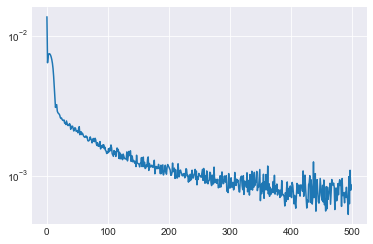

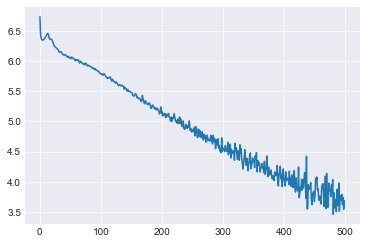

In [42]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


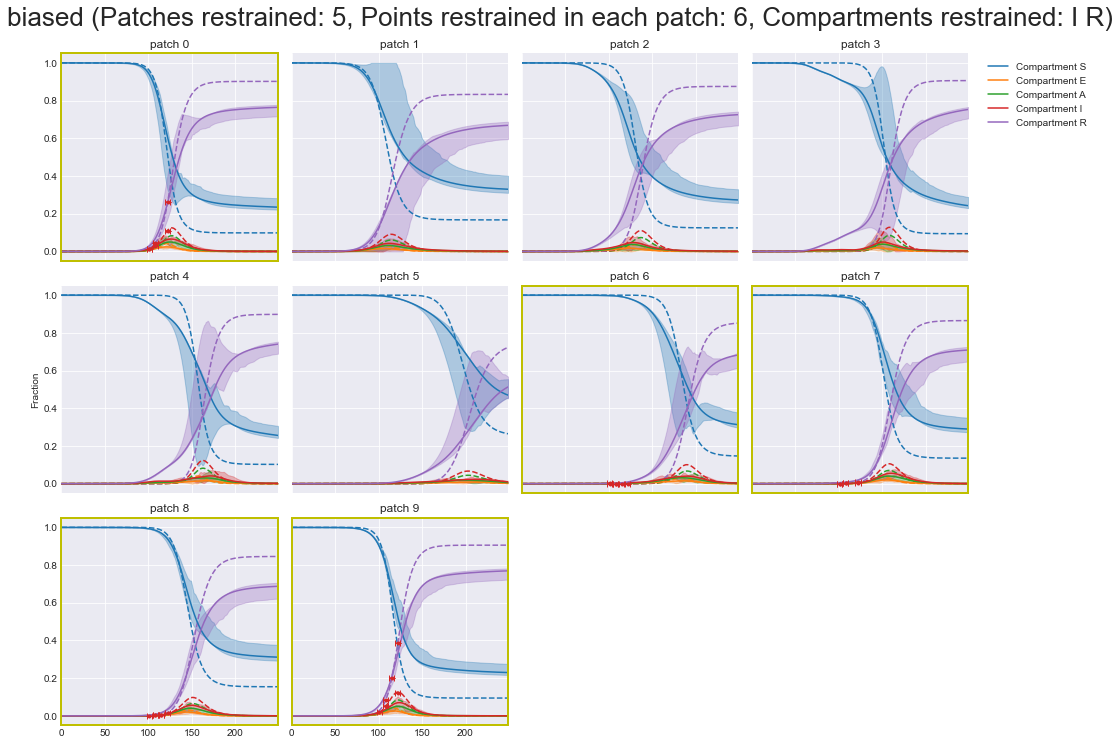

In [43]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

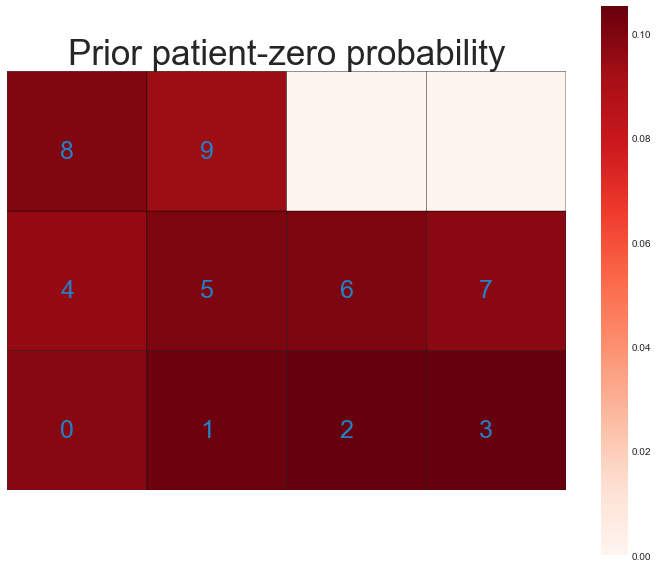

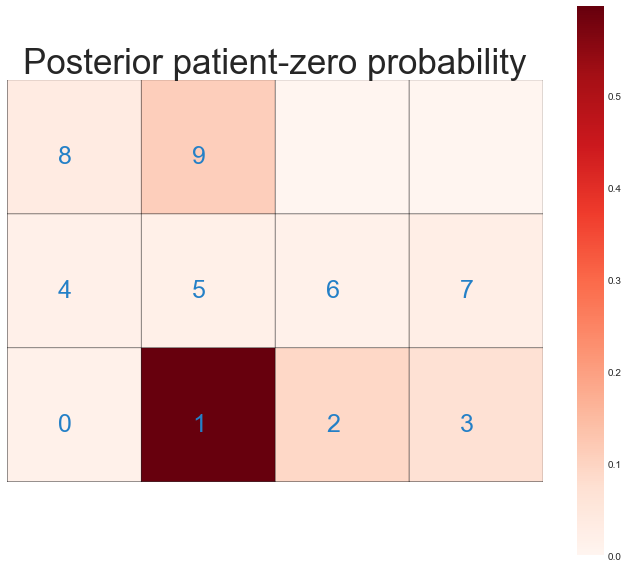

In [44]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


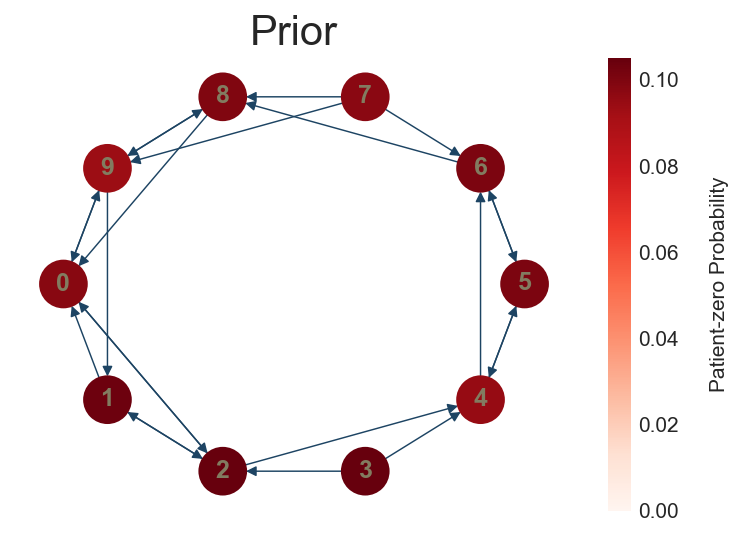

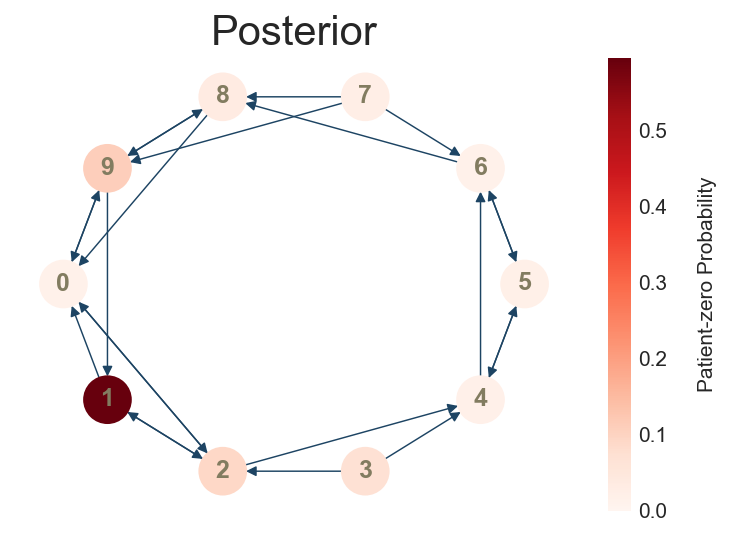

In [45]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [48]:
traj_rmse_4 = traj_loss(sparse_ref_traj_4, sparse_trajs_4, me_w_4)
p0_loss_4 = p0_loss(sparse_trajs_4,me_w_4)
print(f'P0 cross-entropy : {p0_loss_4:.3f}, Traj RMSE : {traj_rmse_4:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

P0 cross-entropy : 0.935, Traj RMSE : 0.074
Top 5 posterior probabilities for P0: 
 [(0.5968307699700386, 'patch 1'), (0.11153765489150538, 'patch 9'), (0.09112873854753122, 'patch 2'), (0.0705572282198358, 'patch 3'), (0.03655962567084524, 'patch 8')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

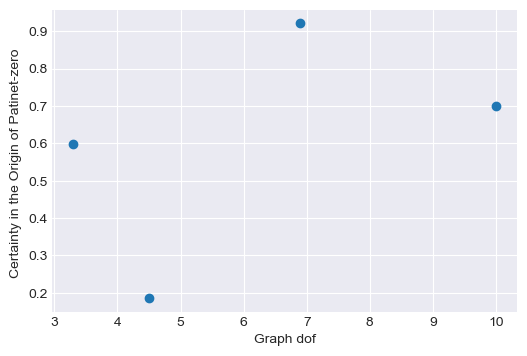

In [47]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')